# Image Colorization basic implementation with CNN

https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn

https://www.freecodecamp.org/news/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d

https://learnopencv.com/convolutional-neural-network-based-image-colorization-using-opencv/

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
color_dir = os.path.join('..', 'data', 'train', 'opt')
gray_dir = os.path.join('..', 'data', 'train', 'sar')

In [4]:
print(os.listdir(color_dir)[:5])
print(os.listdir(gray_dir)[:5])

['1.png', '10.png', '100.png', '1000.png', '10000.png']
['1.png', '10.png', '100.png', '1000.png', '10000.png']


(256, 256, 3)

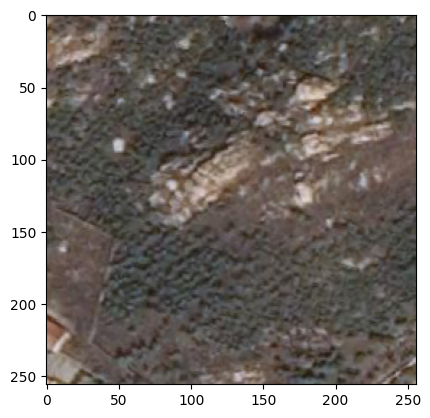

In [5]:
SIZE = 256
img = cv2.imread(os.path.join(color_dir, '1.png'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))
plt.imshow(img)
img.shape

(256, 256, 3)

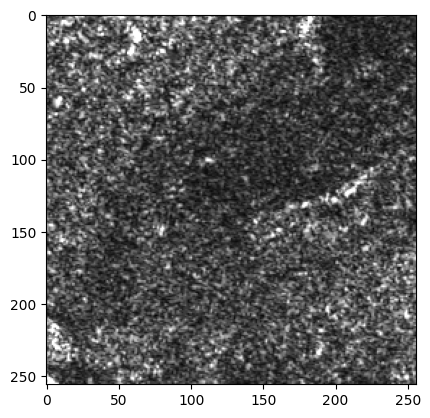

In [6]:
SIZE = 256
img = cv2.imread(os.path.join(gray_dir, '1.png'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))
plt.imshow(img)
img.shape

In [7]:
HEIGHT = SIZE
WIDTH = SIZE
ImagePath = color_dir
N = 500

def ExtractInput(path):
    X_img = []
    y_img = []
    for imageDir in os.listdir(ImagePath)[:N]:
        try:
            img = cv2.imread(os.path.join(ImagePath, imageDir))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            #img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [8]:
X_, y_ = ExtractInput(ImagePath)

In [9]:
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU,concatenate
from keras.models import Model

def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [10]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [11]:
from keras.optimizers import Adam

LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           4,640 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 256, 256, 32)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 32)      │             128 │ leaky_re_lu_1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 128, 128, 64)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 64)      │             256 │ leaky_re_lu_2[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 64)        │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 128)       │             512 │ leaky_re_lu_3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 820,386 (3.13 MB)

 Trainable params: 819,042 (3.12 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [12]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,SIZE,SIZE,1)
        y_input = y_[i].reshape(1,SIZE,SIZE,2)
        yield (X_input,y_input)

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X_,y_, random_state=42)

Model_Colourization.fit(
    GenerateInputs(X_, y_),
    epochs=50, 
    verbose=1,
    steps_per_epoch=38,
    validation_data=GenerateInputs(X_val, y_val),
    validation_steps=10
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 736ms/step - loss: 0.1242 - val_loss: 0.8025
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 764ms/step - loss: 0.0105 - val_loss: 0.7550
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 740ms/step - loss: 0.0045 - val_loss: 0.6520
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - loss: 3.7096e-04 - val_loss: 0.4034
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - loss: 6.7835e-04 - val_loss: 0.2303
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 747ms/step - loss: 6.2865e-04 - val_loss: 0.1176
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - loss: 5.3363e-04 - val_loss: 0.0540
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - loss: 5.6881e-04 - val_loss: 0.0103
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 774ms/step - loss: 0.0044 - val_loss: 0.0130
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 751ms/step - loss: 4.2913e-04 - val_loss: 0.0033
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - loss: 2.6587e-04 - val_loss: 0.0015
Epoch 12/50
3

C:\Users\Naman\Desktop\Repos\sar\model\env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 2.3665e-04 - val_loss: 7.5386e-04
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.8782e-04 - val_loss: 0.0035
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.9992e-04 - val_loss: 0.0117
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 7.5475e-04 - val_loss: 0.0090
Epoch 21/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.9363e-04 - val_loss: 0.0061
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.4970e-04 - val_loss: 0.0043
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.3101e-04 - val_loss: 0.0055
Epoch 24/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 25/50
38/38 ━━━━━━━━━━━━━━━

In [13]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,SIZE,SIZE,1)
    
    return img_l_reshaped

In [14]:
TestImagePath = os.path.join('..', 'data', 'test', 'opt')
ImagePath = os.path.join(TestImagePath, "7.png")
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(SIZE,SIZE,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


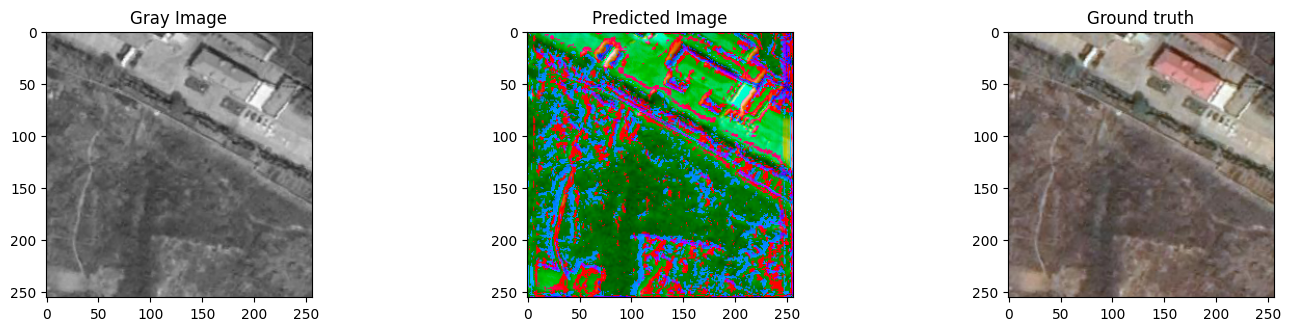

In [15]:
plt.figure(figsize=(30, 20))
plt.subplot(5,5,1)
img = cv2.imread(os.path.join(TestImagePath, "7.png"))
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (SIZE, SIZE))
plt.title("Gray Image")
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

## Evaluation

### 1. Mean Squared Error (MSE)

In [16]:
def mse(image_true, image_pred):
    return np.mean((image_true - image_pred) ** 2)

In [17]:
mse(img_1, img_)

np.float64(109.84873962402344)

### 2. Peak Signal-to-Noise Ratio (PSNR)

In [18]:
def psnr(image_true, image_pred):
    return cv2.PSNR(image_true, image_pred)

In [19]:
psnr(img_1, img_)

8.002967327599288

### 3. Structural Similarity Index (SSIM)

In [20]:
from skimage.metrics import structural_similarity as ssim
def ssim_score(image_true, image_pred):
    return ssim(image_true, image_pred, win_size=3, channel_axis=-1)

In [21]:
ssim_score(img_1, img_)

np.float64(0.175825275997338)

### 4. Perceptual Loss (VGG Loss)

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

def perceptual_loss(y_true, y_pred):
    # Load pre-trained VGG16
    vgg = VGG16(include_top=False, weights="imagenet")
    
    # Create a feature extractor model
    model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
    
    # Ensure input has batch dimension
    y_true = tf.expand_dims(y_true, axis=0)  # Add batch dimension
    y_pred = tf.expand_dims(y_pred, axis=0)  # Add batch dimension

    return tf.reduce_mean(tf.square(model(y_true) - model(y_pred)))

tensor_img_1 = tf.convert_to_tensor(img_1, dtype=tf.float32)  # Ensure correct dtype
tensor_img_ = tf.convert_to_tensor(img_, dtype=tf.float32)

In [23]:
perceptual_loss(tensor_img_1, tensor_img_)

<tf.Tensor: shape=(), dtype=float32, numpy=1308178.875>

## Saving the model

In [24]:
Model_Colourization.save('../models/CNN-colorization.keras')